# Essential Library Imports

In [10]:
import re
import os
import math
import torch
import faiss
import logging
import ir_datasets
import numpy as np
from tqdm import tqdm
import faiss.contrib.torch_utils
from torch.utils.data import Dataset
from typing import Dict, List, Tuple, Optional, Any, Union
from torch import Tensor
import torch.nn.functional as F
from transformers import (
    AutoConfig,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    set_seed
)
from transformers.trainer_utils import is_main_process
from transformers import BertModel

In [11]:
logger = logging.getLogger(__name__)
logging.basicConfig(
    format="%(message)s",
    level=logging.INFO
)

# Configuration and Dense Model Architecture Setup

In [16]:
# Setting constants
SIMILARITY_METRIC_IP = "ip"
SIMILARITY_METRIC_COS = "cos"
SIMILARITY_METRICS = [SIMILARITY_METRIC_IP, SIMILARITY_METRIC_COS]
POOLING_AVERAGE = "average"
POOLING_CLS = "cls"
POOLING_METHODS = [POOLING_AVERAGE, POOLING_CLS]
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # Taking a single GPU environment as an example.

# Parameter settings
class Args:
    # Model parameters
    backbone_name_or_path = "/home/jiahao_zhao/IntelligenceTest/bge-base-en-v1.5"
    # You can freely choose any dense retrieval model you need. 
    # Here we'll use bge-base-en-v1.5 as an example (https://huggingface.co/BAAI/bge-base-en-v1.5)
    similarity_metric = SIMILARITY_METRIC_COS
    pooling = POOLING_CLS
    # Data parameters
    dataset_name = "beir/fiqa"  # Dataset loaded using ir_datasets
    out_dir = "./outputs"  # Output directory
    save_corpus_embed = True
    save_query_embed = True
    # Evaluation parameters, note that due to faiss library limitations, if topk is set larger than 2048, 
    # then use_cpu = True needs to be used when creating the index
    topk = 10000
    search_batch = 120
    
    overwrite_output_dir = False
    per_device_eval_batch_size = 32
    local_rank = -1 # Taking a single GPU environment as an example.
    seed = 2025
    fp16 = True
    dataloader_num_workers = 4

args = Args()

# Set random seed
set_seed(args.seed)

# Model definition
def extract_text_embed(
    last_hidden_state: Tensor,
    attention_mask: Tensor,
    similarity_metric: str,
    pooling: str
):
    if pooling == POOLING_CLS:
        text_embeds = last_hidden_state[:, 0]
    elif pooling == POOLING_AVERAGE:
        masked_hidden = last_hidden_state.masked_fill(~attention_mask[..., None].bool(), 0.)
        text_embeds = masked_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]
    else:
        raise NotImplementedError()
    
    if similarity_metric == SIMILARITY_METRIC_IP:
        pass
    elif similarity_metric == SIMILARITY_METRIC_COS:
        text_embeds = F.normalize(text_embeds, p=2, dim=-1)
    else:
        raise NotImplementedError()
    
    return text_embeds

class BertDense(BertModel):
    def forward(self, input_ids, attention_mask, token_type_ids=None, position_ids=None, return_dict=False):
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            return_dict=True,
        )
        
        pooling = getattr(self.config, "pooling")
        similarity_metric = getattr(self.config, "similarity_metric")
        
        text_embeds = extract_text_embed(
            last_hidden_state=outputs.last_hidden_state,
            attention_mask=attention_mask,
            similarity_metric=similarity_metric,
            pooling=pooling,
        )
        
        if return_dict:
            outputs.embedding = text_embeds
            return outputs
        else:
            return text_embeds

# Auto model class factory for loading specific types of models
class AutoDenseModel:
    @classmethod
    def from_pretrained(cls, model_path: str, config = None):
        if config is None:
            config = AutoConfig.from_pretrained(model_path)
        elif config.model_type == "bert":
            model = BertDense.from_pretrained(model_path, config=config)
        else:
            raise NotImplementedError()
        return model

# Data Processing and Dense Retrieval tools

In [13]:
# Data processing functions
def load_corpus_from_ir_dataset(dataset):
    """
    Load corpus from ir_datasets
    You can replace this with your needed dataset
    returns a dictionary with id as key and document content as value
    """
    corpus = {}
    for doc in tqdm(dataset.docs_iter(), desc="Loading corpus"):
        doc_id = doc[0]
        text = doc[1]  
        corpus[doc_id] = text
    return corpus

def load_queries_from_ir_dataset(dataset):
    """
    Load queries from ir_datasets
    You can replace this with your needed dataset
    returns a dictionary with id as key and document content as value
    """
    queries = {}
    for query in dataset.queries_iter():
            queries[query[0]] = query[1]
    return queries

def load_qrels_from_ir_dataset():
    '''
    Load qrels from ir_datasets
    You can replace this with your needed dataset
    returns a dictionary with query_id as key and a list of relevant doc_ids as value
    '''
    from collections import defaultdict
    qrels = defaultdict(list)
    for type_ in ["train", "dev", "test"]: # The qrels in this dataset are divided into three parts, so we need to load them like this
        dataset = ir_datasets.load(f"{args.dataset_name}/{type_}")
        for tmp in dataset.qrels_iter():
            qrels[tmp[0]].append(tmp[1])
    return qrels

class TextDataset(Dataset):
    def __init__(self, text_lst: List[str], text_ids: List[int]=None):
        self.text_lst = text_lst
        self.text_ids = text_ids
        assert self.text_ids is None or len(text_lst) == len(text_ids)
    
    def __len__(self):
        return len(self.text_lst)

    def __getitem__(self, item):
        if self.text_ids is not None:
            return self.text_ids[item], self.text_lst[item]
        else:
            return self.text_lst[item]

def get_collator_func(tokenizer, max_length):
    def collator_fn(batch):
        if isinstance(batch[0], tuple):
            ids = torch.LongTensor([x[0] for x in batch])
            features = tokenizer([x[1] for x in batch], padding=True, truncation=True, max_length=max_length)
            return {
                'input_ids': torch.LongTensor(features['input_ids']),
                'attention_mask': torch.LongTensor(features['attention_mask']),
                'text_ids': ids,
            }
        else:
            assert isinstance(batch[0], str)
            features = tokenizer(batch, padding=True, truncation=True, max_length=max_length)
            return {
                'input_ids': torch.LongTensor(features['input_ids']),
                'attention_mask': torch.LongTensor(features['attention_mask']),
            }
    return collator_fn

class DenseEvaluater(Trainer):
    '''
    Inherits from trainer, has a predictions attribute, when called it will call this model's predict_step
    '''
    def prediction_step(
        self,
        model,
        inputs: Dict[str, Union[torch.Tensor, Any]],
        prediction_loss_only: bool,
        ignore_keys: Optional[List[str]] = None,
    ) -> Tuple[Optional[torch.Tensor], Optional[torch.Tensor], Optional[torch.Tensor]]:
        
        assert prediction_loss_only == False
        assert ignore_keys is None
        inputs = self._prepare_inputs(inputs)
        with torch.no_grad():
            loss = None
            with self.autocast_smart_context_manager():
                logits = model(**inputs).detach().contiguous()
        return (loss, logits, None)

# Encoding and indexing functions
def encode_dense_corpus(corpus: Dict[Union[str, int], str], model, 
        tokenizer, eval_args, split_corpus_num=1, return_embeds=True, verbose=True):
    logger.info("Sorting Corpus by document length (Longest first)...")
    if re.search("[\u4e00-\u9FFF]", list(corpus.values())[0]):
        logger.info("Automatically detect the corpus is in chinese and will use len(str) to sort the corpus for efficiently encoding")
        corpus_ids = np.array(sorted(corpus, key=lambda k: len(corpus[k]), reverse=True))
    else:
        logger.info("Use len(str.split()) to sort the corpus for efficiently encoding")
        corpus_ids = np.array(sorted(corpus, key=lambda k: len(corpus[k].split()), reverse=True)) # For English, sort by the length after tokenization
    
    if return_embeds:
        corpus_embeds = np.empty((len(corpus_ids), model.config.hidden_size), dtype=np.float32)
        write_num = 0
    else:
        corpus_embeds = None
    
    # Create training parameters
    train_args = TrainingArguments(
        output_dir=eval_args.out_dir,
        per_device_eval_batch_size=eval_args.per_device_eval_batch_size,
        local_rank=eval_args.local_rank,
        fp16=eval_args.fp16,
        dataloader_num_workers=eval_args.dataloader_num_workers
    )
    
    for doc_ids in tqdm(np.array_split(corpus_ids, split_corpus_num),
            disable=not verbose, desc="Split corpus encoding"):
        doc_text = [corpus[did] for did in doc_ids]
        doc_dataset = TextDataset(
            doc_text, 
        )
        doc_out = DenseEvaluater(
            model=model,
            args=train_args,
            data_collator=get_collator_func(tokenizer, 512),
            tokenizer=tokenizer,
        ).predict(doc_dataset)
        if return_embeds:
            doc_embeds = doc_out.predictions
            assert len(doc_embeds) == len(doc_text)
            corpus_embeds[write_num:write_num+len(doc_embeds)] = doc_embeds
            write_num += len(doc_embeds)
    return corpus_embeds, corpus_ids

def encode_dense_query(queries: Dict[Union[str, int], str], model, tokenizer, eval_args):
    logger.info("Encoding Queries...")
    query_ids = sorted(list(queries.keys()))
    queries_text = [queries[qid] for qid in query_ids]
    query_dataset = TextDataset(queries_text)
    
    # Create training parameters
    train_args = TrainingArguments(
        output_dir=eval_args.out_dir,
        per_device_eval_batch_size=eval_args.per_device_eval_batch_size,
        local_rank=eval_args.local_rank,
        fp16=eval_args.fp16,
        dataloader_num_workers=eval_args.dataloader_num_workers
    )
    
    query_out = DenseEvaluater(
        model=model,
        args=train_args,
        data_collator=get_collator_func(tokenizer, 512),
        tokenizer=tokenizer,
    ).predict(query_dataset)
    query_embeds = query_out.predictions
    assert len(query_embeds) == len(queries_text)
    return query_embeds, np.array(query_ids)


def create_index(corpus_embeds: np.ndarray, single_gpu_id=None, use_cpu=False):
    index = faiss.IndexFlatIP(corpus_embeds.shape[1])
    if use_cpu:
        # Create a CPU index
        index.add(corpus_embeds)
        return index
    
    res = faiss.StandardGpuResources()
    co = faiss.GpuClonerOptions()
    co.useFloat16 = True
    co.shard = False
    index = faiss.index_cpu_to_gpu(res, single_gpu_id, index, co)
    index.add(corpus_embeds)
    return index

def dense_search(query_ids: np.ndarray, query_embeds:np.ndarray, 
    corpus_ids: np.ndarray, index: faiss.IndexFlatIP, topk: int):
    topk_scores, topk_idx = index.search(query_embeds, topk)
    topk_ids = np.vstack([corpus_ids[x] for x in topk_idx])
    assert len(query_ids) == len(topk_scores) == len(topk_ids)
    return topk_scores, topk_ids

def batch_dense_search(query_ids: np.ndarray, query_embeds:np.ndarray, 
    corpus_ids: np.ndarray, index: faiss.IndexFlatIP, 
    topk: int, batch_size: int):

    all_topk_scores, all_topk_ids = [], []
    iterations = math.ceil(len(query_ids) / batch_size)
    for query_id_iter, query_embeds_iter in tqdm(zip(
        np.array_split(query_ids, iterations), 
        np.array_split(query_embeds, iterations),
    ), total=iterations, desc="Batch search"):
        topk_scores, topk_ids = dense_search(
            query_id_iter, query_embeds_iter,
            corpus_ids, index, topk
        )
        all_topk_scores.append(topk_scores)
        all_topk_ids.append(topk_ids)
    all_topk_scores = np.concatenate(all_topk_scores, axis=0)
    all_topk_ids = np.concatenate(all_topk_ids, axis=0)
    return all_topk_scores, all_topk_ids

# Functions to load or encode corpus and queries
def load_or_encode_corpus(model, tokenizer, dataset_name, out_dir, args):
    out_corpus_dir = os.path.join(out_dir, "corpus")
    os.makedirs(out_corpus_dir, exist_ok=True)
    
    out_corpus_embed_path = os.path.join(out_corpus_dir, "corpus_embeds.npy")
    out_corpus_ids_path = os.path.join(out_corpus_dir, "corpus_ids.npy")
    
    if (not args.overwrite_output_dir) and os.path.exists(out_corpus_embed_path) and os.path.exists(out_corpus_ids_path):
        if is_main_process(args.local_rank):
            corpus_ids = np.load(out_corpus_ids_path)
            print("load begin.")
            corpus_embeds = np.load(out_corpus_embed_path)
            logger.info("Load pre-computed corpus representations")
        else:
            corpus_embeds, corpus_ids = None, None
    else:
        dataset = ir_datasets.load(dataset_name)
        corpus = load_corpus_from_ir_dataset(dataset)
        corpus_embeds, corpus_ids = encode_dense_corpus(
            corpus, model, tokenizer, args, 
            split_corpus_num=math.ceil(len(corpus)/100_000), 
            return_embeds=is_main_process(args.local_rank), 
            verbose=is_main_process(args.local_rank)
        )
        
        if is_main_process(args.local_rank) and args.save_corpus_embed:
            os.makedirs(out_corpus_dir, exist_ok=True)
            np.save(out_corpus_embed_path, corpus_embeds)
            np.save(out_corpus_ids_path, corpus_ids)
    
    return corpus_embeds, corpus_ids

def load_or_encode_query(model, tokenizer, dataset_name, out_dir, args):
    out_query_dir = os.path.join(out_dir, "query")
    os.makedirs(out_query_dir, exist_ok=True)
    
    out_query_embed_path = os.path.join(out_query_dir, "query_embeds.npy")
    out_query_ids_path = os.path.join(out_query_dir, "qids.npy")
    
    if (not args.overwrite_output_dir) and os.path.exists(out_query_embed_path) and os.path.exists(out_query_ids_path):
        if is_main_process(args.local_rank):
            query_embeds = np.load(out_query_embed_path)
            query_ids = np.load(out_query_ids_path)
            logger.info("Load pre-computed query representations")
        else:
            query_embeds, query_ids = None, None
    else:
        dataset = ir_datasets.load(dataset_name)
        queries = load_queries_from_ir_dataset(dataset)
        query_embeds, query_ids = encode_dense_query(queries, model, tokenizer, args)
        
        if is_main_process(args.local_rank) and args.save_query_embed:
            os.makedirs(out_query_dir, exist_ok=True)
            np.save(out_query_embed_path, query_embeds)
            np.save(out_query_ids_path, query_ids)
    
    return query_embeds, query_ids

def search_and_compute_metrics(index, corpus_ids, query_embeds, query_ids, args):
    qrels = load_qrels_from_ir_dataset()
    all_topk_scores, all_topk_ids = batch_dense_search(
        query_ids, query_embeds, 
        corpus_ids, index, args.topk, 
        batch_size=args.search_batch
    )
    ans = []
    for qid, topk_scores, topk_ids in zip(query_ids, all_topk_scores, all_topk_ids):
        fail = True
        for i, (score, docid) in enumerate(zip(topk_scores, topk_ids)):
            if docid in qrels[qid]:
                ans.append(i + 1)
                fail = False
        if fail:
            ans.append(-1)
    return ans

# Main Function for Dense Retrieval 

In [17]:

def run_dense_retrieval():
    # Load model configuration and tokenizer
    config = AutoConfig.from_pretrained(args.backbone_name_or_path)
    config.similarity_metric = args.similarity_metric
    config.pooling = args.pooling
    
    tokenizer = AutoTokenizer.from_pretrained(args.backbone_name_or_path, config=config)
    model = AutoDenseModel.from_pretrained(args.backbone_name_or_path, config=config)    

    os.makedirs(args.out_dir, exist_ok=True)
    
    query_embeds, query_ids = load_or_encode_query(model, tokenizer, args.dataset_name, args.out_dir, args)
    torch.cuda.empty_cache()
    
    corpus_embeds, corpus_ids = load_or_encode_corpus(model, tokenizer, args.dataset_name, args.out_dir, args)
    torch.cuda.empty_cache()
    
    if is_main_process(args.local_rank):
        index = create_index(corpus_embeds, single_gpu_id=0 if args.local_rank < 0 else args.local_rank, use_cpu=True)
        ans = search_and_compute_metrics(index, corpus_ids, query_embeds, query_ids, args)
        return ans
    
    return None

query2doc_failure_cnts = run_dense_retrieval()

Load pre-computed query representations
Load pre-computed corpus representations


load begin.


Batch search: 100%|██████████| 56/56 [00:15<00:00,  3.66it/s]


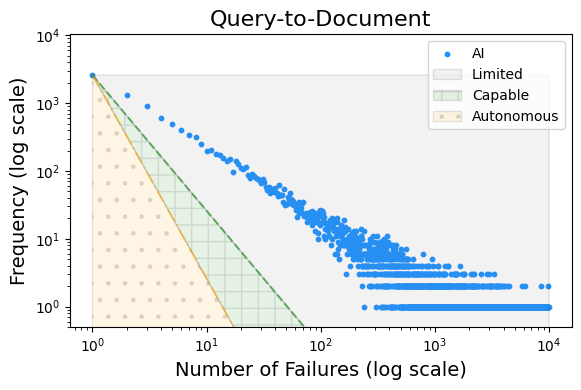

In [18]:
import matplotlib.pyplot as plt
import numpy as np

frequency = np.zeros(max(query2doc_failure_cnts) + 1)

for cnt in query2doc_failure_cnts:
    if cnt > 0 and cnt < len(frequency):
        frequency[cnt] += 1

plt.figure(figsize=(6, 4))

x = np.array(range(1, max(query2doc_failure_cnts) + 1))
# Plot histogram
plt.scatter(x, frequency[x], color="dodgerblue", s=10, label="AI")

y1 = (x.astype(np.float32))**-2 * frequency[1]
y2 = (x.astype(np.float32))**-3 * frequency[1]

# Draw two boundary lines # label=r'$y \propto x^{-2}$',# label=r'$y \propto x^{-3}$',
plt.plot(x, y1,  color='green', linestyle='--', alpha=0.5) 
plt.plot(x, y2,  color='orange', linestyle='-.', alpha=0.5) 

# Fill different regions between the curves
plt.fill_between(x, frequency[1], y1, color='gray', alpha=0.1, label="Limited", edgecolor="black")
plt.fill_between(x, y1, y2, color='green', alpha=0.1, hatch='+', label="Capable", edgecolor="black")
plt.fill_between(x, y2,0, color='orange', alpha=0.1, hatch='.', label="Autonomous", edgecolor="black")

# Set x-axis to log scale
plt.xscale('log')
# Set y-axis to log scale
plt.yscale('log')

# Set labels and title
plt.xlabel('Number of Failures (log scale)', fontsize=14)
plt.ylabel('Frequency (log scale)', fontsize=14)
plt.title(f'Query-to-Document', fontsize=16)

plt.tight_layout()

plt.legend(loc='upper right')

# set ylim lower bound to min(frequency)
plt.ylim(bottom=min(frequency[frequency > 0] / 2))

plt.show()